# Using ARIMA and SARIMAX to Forecast Sales

In [72]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('../data/processed/cleaned.csv', parse_dates=['Date'])

In [80]:
df.head()

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y
0,0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106,False
1,1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,211.242170,8.106,True
2,2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,211.289143,8.106,False
3,3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,211.319643,8.106,False
4,4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,211.350143,8.106,False


In [5]:
# Group by 'Date' and sum 'Weekly_Sales'
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Resulting dataframe
print(weekly_sales)

          Date  Weekly_Sales
0   2010-02-05   49750740.50
1   2010-02-12   48336677.63
2   2010-02-19   48276993.78
3   2010-02-26   43968571.13
4   2010-03-05   46871470.30
..         ...           ...
138 2012-09-28   43734899.40
139 2012-10-05   47566639.31
140 2012-10-12   46128514.25
141 2012-10-19   45122410.57
142 2012-10-26   45544116.29

[143 rows x 2 columns]


In [6]:
weekly_sales.describe()

,Date,Weekly_Sales
count,143,1.430000e+02
mean,2011-06-17 00:00:00,4.711342e+07
min,2010-02-05 00:00:00,3.959985e+07
25%,2010-10-11 12:00:00,4.488059e+07
50%,2011-06-17 00:00:00,4.624390e+07
75%,2012-02-20 12:00:00,4.779202e+07
max,2012-10-26 00:00:00,8.093142e+07
std,NaN,5.444206e+06


In [7]:
weekly_sales.info()
weekly_sales.head()
print(weekly_sales.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   Weekly_Sales  143 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB
Index(['Date', 'Weekly_Sales'], dtype='object')


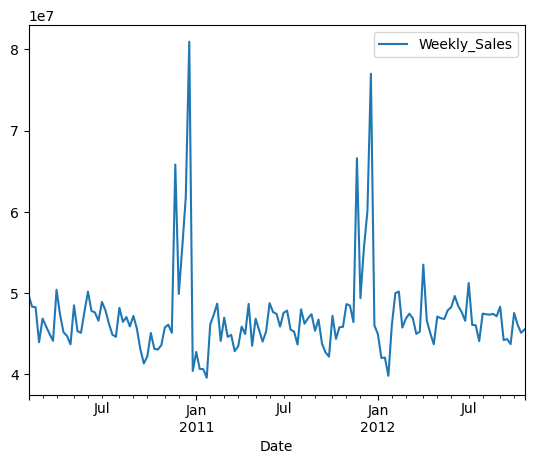

In [8]:
weekly_sales.plot(x='Date', y='Weekly_Sales')
plt.show()

In [9]:
## Testing for stationarity

from statsmodels.tsa.stattools import adfuller

In [10]:
test_result = adfuller(weekly_sales['Weekly_Sales'])

In [11]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ["ADF Test Statistic", "p-value", "Lags Used", "Number of Observations Used"]
    for value, label in zip(result, labels):
        print(f'{label} : {value}')
    if result[1] <= 0.5:
        print("Data has no unit and is stationary")
    else:
        print("Time series has a unit root, indicating it is non-stationary")

In [12]:
adfuller_test(weekly_sales['Weekly_Sales'])

ADF Test Statistic : -5.908297957186329
p-value : 2.6759791589860825e-07
Lags Used : 4
Number of Observations Used : 138
Data has no unit and is stationary


In [13]:
weekly_sales['Seasonal First Differencec'] = weekly_sales['Weekly_Sales'] - weekly_sales['Weekly_Sales'].shift(52)
weekly_sales.tail()

,Date,Weekly_Sales,Seasonal First Differencec
138,2012-09-28,43734899.40,1539068.59
139,2012-10-05,47566639.31,354950.95
140,2012-10-12,46128514.25,1753693.95
141,2012-10-19,45122410.57,-696542.87
142,2012-10-26,45544116.29,-311704.76


In [14]:
adfuller_test(weekly_sales['Seasonal First Differencec'].dropna())

ADF Test Statistic : -7.3890265507020985
p-value : 8.092496623964305e-11
Lags Used : 0
Number of Observations Used : 90
Data has no unit and is stationary


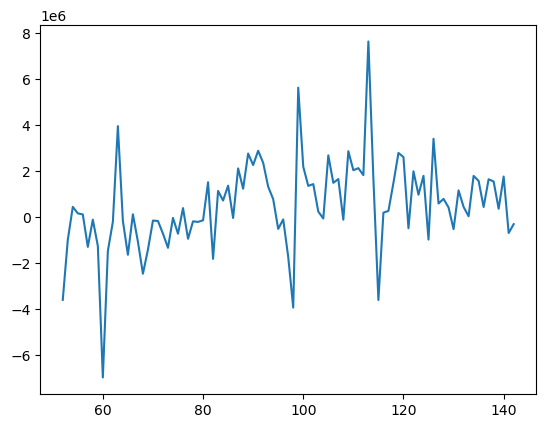

In [15]:
weekly_sales['Seasonal First Differencec'].plot()
plt.show()

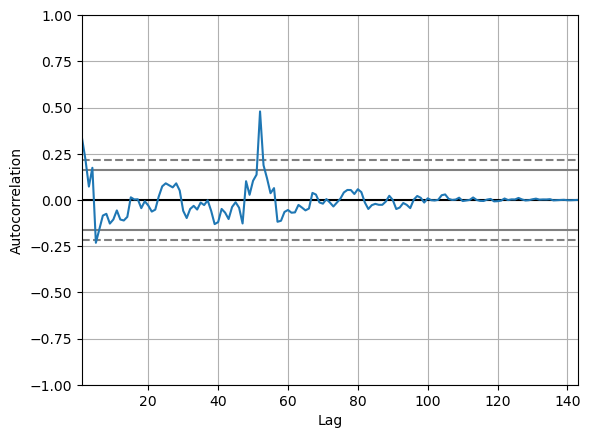

In [16]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(weekly_sales['Weekly_Sales'])
plt.show()

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

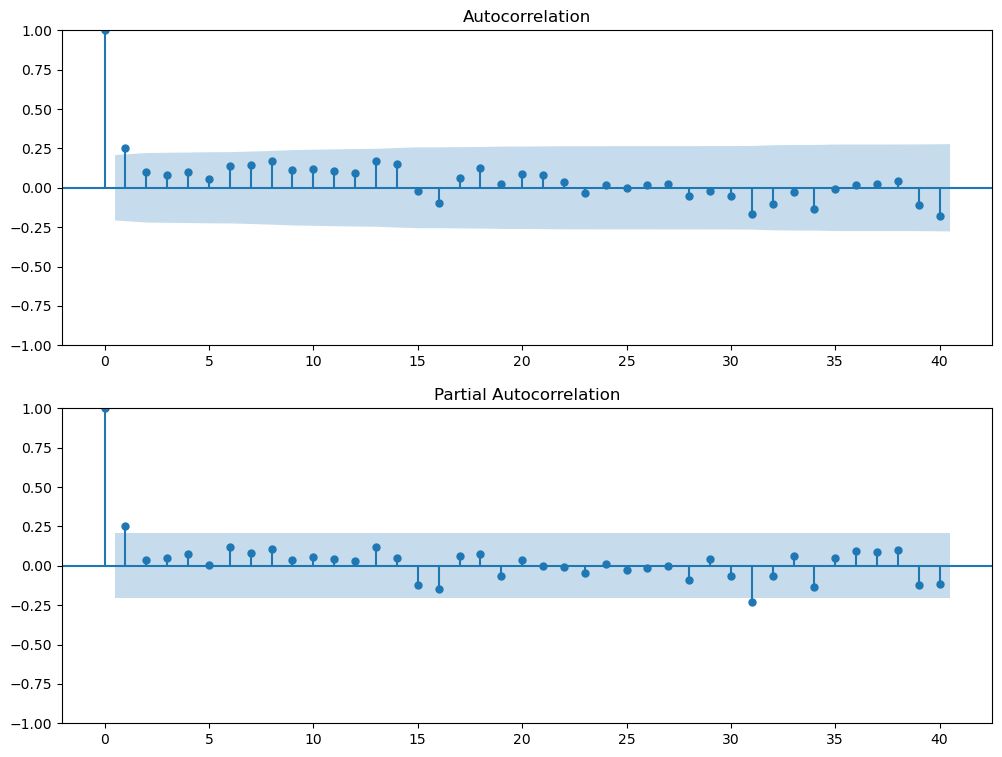

In [18]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(211)
fig = plot_acf(weekly_sales['Seasonal First Differencec'].iloc[54:], lags=40, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(weekly_sales['Seasonal First Differencec'].iloc[54:], lags=40, ax=ax2)

plt.show()

In [19]:
from statsmodels.tsa.arima.model import ARIMA

In [20]:
model = ARIMA(weekly_sales['Weekly_Sales'], order=(1, 1, 1))
model_fit = model.fit()

In [21]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2407.205
Date:                Sun, 01 Jun 2025   AIC                           4820.410
Time:                        16:30:34   BIC                           4829.277
Sample:                             0   HQIC                          4824.013
                                - 143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4556      0.065      6.965      0.000       0.327       0.584
ma.L1         -0.9767      0.038    -25.432      0.000      -1.052      -0.901
sigma2      3.067e+13   7.95e-16   3.86e+28      0.000    3.07e+13    3.07e+13
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):               525.93
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             1.37
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.61e+43. Standard errors may be unstable.
"""

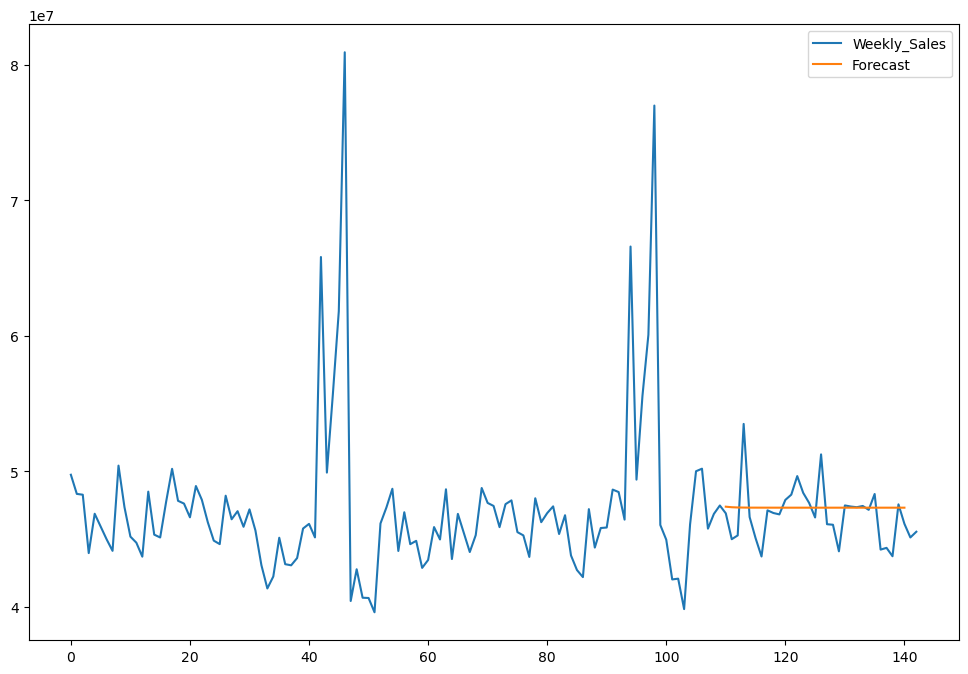

In [22]:
weekly_sales['Forecast'] = model_fit.predict(start=110, end=140, dynamic=True)
weekly_sales[['Weekly_Sales', 'Forecast']].plot(figsize=(12, 8))
plt.show()

In [23]:
import statsmodels.api as sm

In [24]:
model = sm.tsa.statespace.SARIMAX(weekly_sales['Weekly_Sales'], seasonal_order=(1,1,1,52))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03438D+01    |proj g|=  1.80836D+00


 This problem is unconstrained.



At iterate    5    f=  1.01952D+01    |proj g|=  3.86994D+00

At iterate   10    f=  1.01369D+01    |proj g|=  9.42348D-03

At iterate   15    f=  1.01365D+01    |proj g|=  4.17857D-01

At iterate   20    f=  1.01146D+01    |proj g|=  1.19735D-01

At iterate   25    f=  1.01125D+01    |proj g|=  4.50359D-02

At iterate   30    f=  1.01106D+01    |proj g|=  6.93526D-03

At iterate   35    f=  1.01099D+01    |proj g|=  3.98259D-03

At iterate   40    f=  1.01097D+01    |proj g|=  1.69409D-02

At iterate   45    f=  1.01095D+01    |proj g|=  2.17995D-03

At iterate   50    f=  1.01094D+01    |proj g|=  1.75418D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


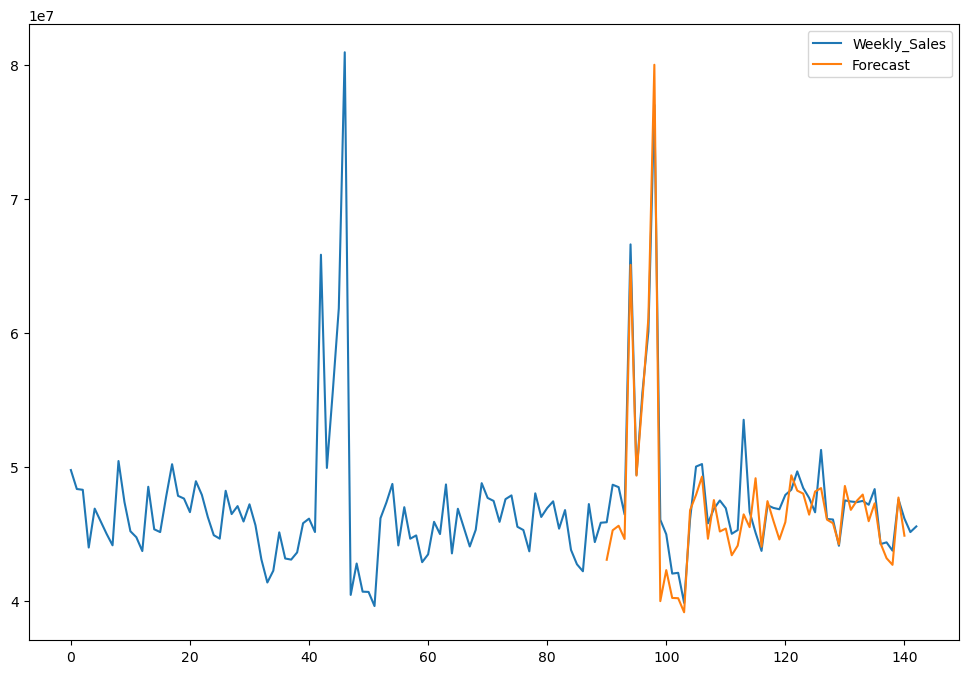

In [25]:
weekly_sales['Forecast'] = results.predict(start=90, end=140, dynamic=True)
weekly_sales[['Weekly_Sales', 'Forecast']].plot(figsize=(12, 8))
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91815D-01    |proj g|=  1.71272D-02


 This problem is unconstrained.



At iterate    5    f=  9.87897D-01    |proj g|=  1.40516D-02

At iterate   10    f=  9.86107D-01    |proj g|=  2.05057D-03

At iterate   15    f=  9.86088D-01    |proj g|=  1.28210D-03

At iterate   20    f=  9.86037D-01    |proj g|=  5.22216D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     35      1     0     0   7.482D-06   9.860D-01
  F =  0.98603747461630809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


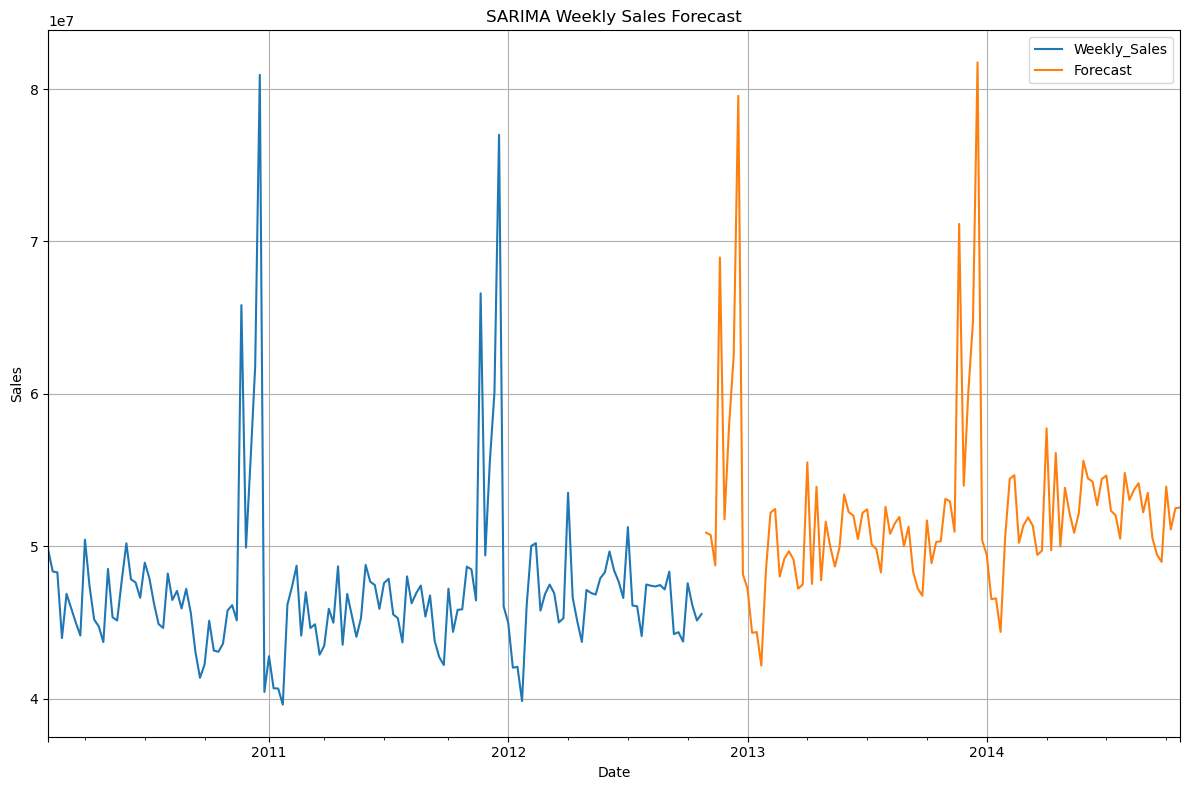

In [104]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Load Data ===
df = pd.read_csv('../data/processed/cleaned.csv', parse_dates=['Date'])

# === Aggregate Weekly Sales Across All Stores and Depts ===
weekly_sales = df.groupby('Date').agg({'Weekly_Sales': 'sum'}).reset_index()

# === Ensure datetime index ===
weekly_sales.index = pd.to_datetime(weekly_sales['Date'])
weekly_sales = weekly_sales.sort_index()

# === Train-Test Split ===
split_point = int(len(weekly_sales) * 0.8)
train = weekly_sales.iloc[:split_point]
test = weekly_sales.iloc[split_point:]

# === Fit SARIMA model ===
model = SARIMAX(train['Weekly_Sales'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# === Forecast on test period ===
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

# === Evaluation ===
y_test = test['Weekly_Sales']
y_pred = forecast_mean

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# === Save metrics to file ===
os.makedirs("../output", exist_ok=True)
with open("../output/sarimax_forecast_metrics.txt", "w") as f:
    f.write(f"RMSE: {rmse:.2f}\n")
    f.write(f"MAPE: {mape:.2f}%\n")
    f.write(f"MAE: {mae:.2f}\n")
    f.write(f"R² Score: {r2:.2f}\n")

# === Future Forecast ===
future_steps = 104  # 2 years ahead
future_forecast = results.predict(start=len(weekly_sales), end=len(weekly_sales)+future_steps-1, dynamic=True)

# Create future dates
future_dates = [weekly_sales.index[-1] + DateOffset(weeks=i) for i in range(1, future_steps + 1)]
fut_dataset = pd.DataFrame(index=future_dates)
fut_dataset['Weekly_Sales'] = None
fut_dataset['Forecast'] = future_forecast.values

# Combine original + forecasted future
fut_df = pd.concat([weekly_sales, fut_dataset])

# === Plot ===
fut_df[['Weekly_Sales', 'Forecast']].plot(figsize=(12, 8), title="SARIMA Weekly Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


In [112]:
fut_df[['Weekly_Sales', 'Forecast']].plot(figsize=(12, 8), title="SARIMA Weekly Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()

# Save plot as PNG
plt.savefig("../output/sarimax_forecast.png")